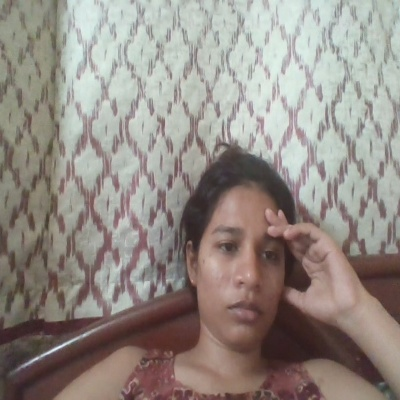

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import math
import pandas as pd
from IPython.display import display, Image, clear_output

# Load the model
model = hub.load("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow1/openimages-v4-ssd-mobilenet-v2/1").signatures["default"]

# Define the target classes to detect
target_classes = []

# Initialize a dictionary to store color codes
colorcodes = {}

# Initialize a list to store detection data
detections_data = []

# Function to draw bounding boxes
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1
    TEXT_Y_OFFSET_SCALE = 0.01

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    cv2.putText(
        image,
        namewithscore,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores):
    global detections_data
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")

        if classname in target_classes:
            if classname in colorcodes.keys():
                color = colorcodes[classname]
            else:
                c1 = random.randrange(0, 255, 30)
                c2 = random.randrange(0, 255, 25)
                c3 = random.randrange(0, 255, 50)
                colorcodes.update({classname: (c1, c2, c3)})
                color = colorcodes[classname]

            namewithscore = "{}:{}".format(classname, int(100 * scores[i]))
            drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color)

            # Store detection data
            detections_data.append({
                "Class": classname,
                "Confidence Score": scores[i],
                "ymin": ymin,
                "xmin": xmin,
                "ymax": ymax,
                "xmax": xmax
            })

    return image

# Real-time object detection
def detect_objects_in_real_time():
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        height, width = 400, 400
        frame = cv2.resize(frame, (width, height))
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(image_rgb, tf.float32)[tf.newaxis, ...]

        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        image_with_boxes = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"])

        clear_output(wait=True)
        _, encoded_image = cv2.imencode('.jpg', image_with_boxes)
        display(Image(data=encoded_image))

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()

    # Save detections to Excel file
    df = pd.DataFrame(detections_data)
    df.to_excel("detections.xlsx", index=False)
    print("Detections saved to detections.xlsx")

# Run the real-time object detection
detect_objects_in_real_time()


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import math
import pandas as pd
from datetime import datetime
import time  # Import time module

# Load the model
model = hub.load("https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow1/openimages-v4-ssd-mobilenet-v2/1").signatures["default"]

# Initialize a dictionary to store color codes
colorcodes = {}

# Function to draw bounding boxes
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1
    TEXT_Y_OFFSET_SCALE = 0.01

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    cv2.putText(
        image,
        namewithscore,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores):
    # Filter detections based on scores
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)
    detections = []

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")
        score = scores[i]
        detections.append((classname, score))

        if classname in colorcodes.keys():
            color = colorcodes[classname]
        else:
            c1 = random.randrange(0, 255, 30)
            c2 = random.randrange(0, 255, 25)
            c3 = random.randrange(0, 255, 50)
            colorcodes.update({classname: (c1, c2, c3)})
            color = colorcodes[classname]

        namewithscore = "{}:{}".format(classname, int(100 * score))
        drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color)

    return image, detections

# Initialize webcam
cap = cv2.VideoCapture(0)

# Create an empty DataFrame to store detections
df = pd.DataFrame(columns=["Time", "Class", "Score"])

# Start the webcam feed
try:
    while True:
        start_time = time.time()  # Record the start time of the loop

        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame for consistent processing
        frame = cv2.resize(frame, (640, 480))
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(frame_rgb, tf.float32)[tf.newaxis, ...]

        # Perform detection
        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        # Draw bounding boxes and get detections
        frame_with_boxes, detections = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"])

        # Display the frame with bounding boxes
        cv2.imshow('Real-time Object Detection', frame_with_boxes)

        # Save detections into DataFrame
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if detections:
            new_rows = pd.DataFrame([(current_time, classname, score) for classname, score in detections], columns=["Time", "Class", "Score"])
            df = pd.concat([df, new_rows], ignore_index=True)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Ensure the loop runs only twice per second
        elapsed_time = time.time() - start_time
        if elapsed_time < 0.5:  # If processing took less than 0.5 seconds, wait for the remaining time
            time.sleep(0.5 - elapsed_time)

finally:
    # Release the webcam and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Save the detections to an Excel file
    df.to_excel("detections.xlsx", index=False)
    print("Detections saved to detections.xlsx")


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import pandas as pd
from datetime import datetime
import time

# Load the optimized MobileNet model
model = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures["default"]

# Initialize a dictionary to store color codes
colorcodes = {}

# Function to draw bounding boxes
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    cv2.putText(
        image,
        namewithscore,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores):
    # Filter detections based on scores
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)
    detections = []

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")
        score = scores[i]
        detections.append((classname, score))

        if classname in colorcodes.keys():
            color = colorcodes[classname]
        else:
            c1 = random.randrange(0, 255, 30)
            c2 = random.randrange(0, 255, 25)
            c3 = random.randrange(0, 255, 50)
            colorcodes.update({classname: (c1, c2, c3)})
            color = colorcodes[classname]

        namewithscore = "{}:{}".format(classname, int(100 * score))
        drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color)

    return image, detections

# Initialize video input (replace 'video_path.mp4' with your actual video file path)
video_path = r"C:\Users\Sami\Downloads\videoplayback.mp4"
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions of the video
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create an empty DataFrame to store detections
df = pd.DataFrame(columns=["Time", "Class", "Score"])

# Start processing the video
try:
    frame_count = 0
    while cap.isOpened():
        start_time = time.time()  # Record the start time of the loop

        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to improve performance (process every 3rd frame)
        frame_count += 1
        if frame_count % 3 != 0:
            continue

        # Convert the frame to RGB format and normalize it for model input
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(frame_rgb, tf.float32)[tf.newaxis, ...]

        # Perform detection
        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        # Draw bounding boxes and get detections
        frame_with_boxes, detections = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"])

        # Display the frame with bounding boxes at its original size
        cv2.imshow('Video Object Detection', cv2.resize(frame_with_boxes, (original_width, original_height)))

        # Save detections into DataFrame
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if detections:
            new_rows = pd.DataFrame([(current_time, classname, score) for classname, score in detections], columns=["Time", "Class", "Score"])
            df = pd.concat([df, new_rows], ignore_index=True)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Cap the frame rate to 10 FPS (0.1s per frame)
        elapsed_time = time.time() - start_time
        if elapsed_time < 0.1:  # If processing took less than 0.1 seconds, wait for the remaining time
            time.sleep(0.1 - elapsed_time)

finally:
    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Save the detections to an Excel file
    df.to_excel("detections.xlsx", index=False)
    print("Detections saved to detections.xlsx")


In [3]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import pandas as pd
from datetime import datetime
import time

# Load the optimized MobileNet model
model = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures["default"]

# Initialize a dictionary to store color codes
colorcodes = {}

# Define some real-world object heights for estimation (in meters)
object_heights = {
    'Person': 1.7,  # Average height of a person in meters
    'Vehicle': 1.5, # Approximate height of a vehicle
    'Bird': 0.3,    # Average height of a bird
    'Airplane': 3.0 # Approximate height of an airplane (from ground)
}

# Focal length (in pixels). This can vary depending on the camera. We'll use an approximation.
# You may need to adjust this based on real-world calibration.
focal_length = 800  # Example focal length in pixels

# Function to calculate the distance to an object
def calculate_distance(object_height, perceived_height, frame_height):
    # Calculate distance using the pinhole camera model
    return (focal_length * object_height) / perceived_height

# Function to draw bounding boxes and distance
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance=None):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    label = namewithscore
    if distance is not None:
        label += f" Dist:{distance:.2f}m"

    cv2.putText(
        image,
        label,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores):
    # Filter detections based on scores
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)
    detections = []

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")
        score = scores[i]
        height_in_pixels = ymax - ymin  # Perceived height of the object in image space

        # Get the real-world height of the object if known, else set to None
        object_height = object_heights.get(classname.capitalize(), None)
        distance = None

        if object_height is not None:
            perceived_height = height_in_pixels * image.shape[0]  # Actual height of the bounding box in pixels
            distance = calculate_distance(object_height, perceived_height, image.shape[0])

        detections.append((classname, score, distance))

        if classname in colorcodes.keys():
            color = colorcodes[classname]
        else:
            c1 = random.randrange(0, 255, 30)
            c2 = random.randrange(0, 255, 25)
            c3 = random.randrange(0, 255, 50)
            colorcodes.update({classname: (c1, c2, c3)})
            color = colorcodes[classname]

        namewithscore = "{}:{}".format(classname, int(100 * score))
        drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance)

    return image, detections

# Initialize video input (replace 'video_path.mp4' with your actual video file path)
video_path = r"C:\Users\Sami\Downloads\videoplayback.mp4"
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions of the video
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create an empty DataFrame to store detections
df = pd.DataFrame(columns=["Time", "Class", "Score", "Distance (m)"])

# Start processing the video
try:
    frame_count = 0
    while cap.isOpened():
        start_time = time.time()  # Record the start time of the loop

        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to improve performance (process every 3rd frame)
        frame_count += 1
        if frame_count % 3 != 0:
            continue

        # Convert the frame to RGB format and normalize it for model input
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(frame_rgb, tf.float32)[tf.newaxis, ...]

        # Perform detection
        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        # Draw bounding boxes and get detections
        frame_with_boxes, detections = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"])

        # Display the frame with bounding boxes at its original size
        cv2.imshow('Video Object Detection', cv2.resize(frame_with_boxes, (original_width, original_height)))

        # Save detections into DataFrame
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if detections:
            new_rows = pd.DataFrame([(current_time, classname, score, dist) for classname, score, dist in detections], columns=["Time", "Class", "Score", "Distance (m)"])
            df = pd.concat([df, new_rows], ignore_index=True)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Cap the frame rate to 10 FPS (0.1s per frame)
        elapsed_time = time.time() - start_time
        if elapsed_time < 0.1:  # If processing took less than 0.1 seconds, wait for the remaining time
            time.sleep(0.1 - elapsed_time)

finally:
    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Save the detections to an Excel file
    df.to_excel("detections_with_distances.xlsx", index=False)
    print("Detections saved to detections_with_distances.xlsx")


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
C:\Users\Sami\AppData\Local\Temp\ipykernel_18332\3306643203.py:149: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


Detections saved to detections_with_distances.xlsx


In [5]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import pandas as pd
from datetime import datetime
import time

# Load the optimized MobileNet model
model = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures["default"]

# Initialize a dictionary to store color codes
colorcodes = {}

# Define some real-world object heights for estimation (in meters)
object_heights = {
    'Person': 1.7,  # Average height of a person in meters
    'Vehicle': 1.5, # Approximate height of a vehicle
    'Bird': 0.3,    # Average height of a bird
    'Airplane': 3.0 # Approximate height of an airplane (from ground)
}

# Focal length (in pixels). This can vary depending on the camera. We'll use an approximation.
# You may need to adjust this based on real-world calibration.
focal_length = 800  # Example focal length in pixels

# Function to calculate the distance to an object
def calculate_distance(object_height, perceived_height, frame_height):
    # Calculate distance using the pinhole camera model
    return (focal_length * object_height) / perceived_height

# Function to draw bounding boxes and distance
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance=None):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    label = namewithscore
    if distance is not None:
        label += f" Dist:{distance:.2f}m"

    cv2.putText(
        image,
        label,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores):
    # Filter detections based on scores
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)
    detections = []

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")
        score = scores[i]
        height_in_pixels = ymax - ymin  # Perceived height of the object in image space

        # Get the real-world height of the object if known, else set to None
        object_height = object_heights.get(classname.capitalize(), None)
        distance = None

        if object_height is not None:
            perceived_height = height_in_pixels * image.shape[0]  # Actual height of the bounding box in pixels
            distance = calculate_distance(object_height, perceived_height, image.shape[0])

        # Calculate approximate coordinates in pixels
        im_height, im_width, _ = image.shape
        left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
        coordinates = (left, top, right, bottom)

        detections.append((classname, score, distance, coordinates))

        if classname in colorcodes.keys():
            color = colorcodes[classname]
        else:
            c1 = random.randrange(0, 255, 30)
            c2 = random.randrange(0, 255, 25)
            c3 = random.randrange(0, 255, 50)
            colorcodes.update({classname: (c1, c2, c3)})
            color = colorcodes[classname]

        namewithscore = "{}:{}".format(classname, int(100 * score))
        drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance)

    return image, detections

# Initialize video input (replace 'video_path.mp4' with your actual video file path)
#video_path = cv2.Videocapture(0)
cap = cv2.VideoCapture(0)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions of the video
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create an empty DataFrame to store detections
df = pd.DataFrame(columns=["Time", "Class", "Score", "Distance (m)", "Coordinates (left, top, right, bottom)"])

# Start processing the video
try:
    frame_count = 0
    while cap.isOpened():
        start_time = time.time()  # Record the start time of the loop

        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to improve performance (process every 3rd frame)
        frame_count += 1
        if frame_count % 3 != 0:
            continue

        # Convert the frame to RGB format and normalize it for model input
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(frame_rgb, tf.float32)[tf.newaxis, ...]

        # Perform detection
        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        # Draw bounding boxes and get detections
        frame_with_boxes, detections = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"])

        # Display the frame with bounding boxes at its original size
        cv2.imshow('Video Object Detection', cv2.resize(frame_with_boxes, (original_width, original_height)))

        # Save detections into DataFrame
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if detections:
            new_rows = pd.DataFrame([(current_time, classname, score, dist, coords) for classname, score, dist, coords in detections], 
                                    columns=["Time", "Class", "Score", "Distance (m)", "Coordinates (left, top, right, bottom)"])
            df = pd.concat([df, new_rows], ignore_index=True)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Cap the frame rate to 10 FPS (0.1s per frame)
        elapsed_time = time.time() - start_time
        if elapsed_time < 0.1:  # If processing took less than 0.1 seconds, wait for the remaining time
            time.sleep(0.1 - elapsed_time)

finally:
    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Save the detections to an Excel file
    df.to_excel("detections_with_distances_and_coordinates.xlsx", index=False)
    print("Detections saved to detections_with_distances_and_coordinates.xlsx")


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
C:\Users\Sami\AppData\Local\Temp\ipykernel_18332\3164694428.py:155: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


Detections saved to detections_with_distances_and_coordinates.xlsx


In [2]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_hub as hub
import random
import pandas as pd
from datetime import datetime
import time

# Load the optimized MobileNet model
model = hub.load("https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1").signatures["default"]

# Initialize a dictionary to store color codes
colorcodes = {}

# Define some real-world object heights for estimation (in meters)
object_heights = {
    'Person': 1.7,  # Average height of a person in meters
    'Vehicle': 1.5, # Approximate height of a vehicle
    'Bird': 0.3,    # Average height of a bird
    'Airplane': 3.0 # Approximate height of an airplane (from ground)
}

# Focal length (in pixels). This can vary depending on the camera.
focal_length = 800  # Example focal length in pixels

# Known reference points (top-left and bottom-right GPS coordinates)
reference_points = {
    'top_left': {'lat': 40.712776, 'lon': -74.005974, 'pixel': (0, 0)},  # Replace with actual GPS coordinates for the top-left corner
    'bottom_right': {'lat': 40.703776, 'lon': -73.995974, 'pixel': (1280, 720)}  # Replace with actual GPS coordinates for bottom-right
}

# Function to calculate the distance to an object using the pinhole camera model
def calculate_distance(object_height, perceived_height, frame_height):
    return (focal_length * object_height) / perceived_height

# Function to convert pixel coordinates to GPS coordinates
def pixel_to_gps(pixel_x, pixel_y, ref_points, img_width, img_height):
    # Get the proportion of the pixel position in the image
    lat_proportion = pixel_y / img_height
    lon_proportion = pixel_x / img_width

    # Calculate the latitude and longitude using linear interpolation
    lat = ref_points['top_left']['lat'] + lat_proportion * (ref_points['bottom_right']['lat'] - ref_points['top_left']['lat'])
    lon = ref_points['top_left']['lon'] + lon_proportion * (ref_points['bottom_right']['lon'] - ref_points['top_left']['lon'])

    return lat, lon

# Function to draw bounding boxes and distances
def drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance=None):
    im_height, im_width, _ = image.shape
    left, top, right, bottom = int(xmin * im_width), int(ymin * im_height), int(xmax * im_width), int(ymax * im_height)
    cv2.rectangle(image, (left, top), (right, bottom), color=color, thickness=2)

    FONT_SCALE = 0.5
    THICKNESS_SCALE = 1

    cv2.rectangle(
        image,
        (left, top - int(20)),
        (right, top),
        color=color,
        thickness=-1
    )

    label = namewithscore
    if distance is not None:
        label += f" Dist:{distance:.2f}m"

    cv2.putText(
        image,
        label,
        (left, top - int(5)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=FONT_SCALE,
        thickness=THICKNESS_SCALE,
        color=(255, 255, 255)
    )

# Function to process detections and draw them on the image
def draw(image, boxes, classnames, scores, img_width, img_height):
    # Filter detections based on scores
    boxesidx = tf.image.non_max_suppression(boxes, scores, max_output_size=10, iou_threshold=0.4, score_threshold=0.3)
    detections = []

    for i in boxesidx:
        ymin, xmin, ymax, xmax = tuple(boxes[i])
        classname = classnames[i].decode("ascii")
        score = scores[i]
        height_in_pixels = ymax - ymin  # Perceived height of the object in image space

        # Get the real-world height of the object if known
        object_height = object_heights.get(classname.capitalize(), None)
        distance = None

        if object_height is not None:
            perceived_height = height_in_pixels * img_height  # Height of the bounding box in pixels
            distance = calculate_distance(object_height, perceived_height, img_height)

        # Calculate pixel coordinates and convert to GPS coordinates
        left, top, right, bottom = int(xmin * img_width), int(ymin * img_height), int(xmax * img_width), int(ymax * img_height)
        gps_coords = pixel_to_gps((left + right) / 2, (top + bottom) / 2, reference_points, img_width, img_height)

        # Append detection details
        detections.append((classname, score, distance, gps_coords))

        if classname in colorcodes.keys():
            color = colorcodes[classname]
        else:
            c1 = random.randrange(0, 255, 30)
            c2 = random.randrange(0, 255, 25)
            c3 = random.randrange(0, 255, 50)
            colorcodes.update({classname: (c1, c2, c3)})
            color = colorcodes[classname]

        namewithscore = "{}:{}".format(classname, int(100 * score))
        drawbox(image, ymin, xmin, ymax, xmax, namewithscore, color, distance)

    return image, detections

# Initialize video input (replace 'video_path.mp4' with your actual video file path)
#video_path = r"C:\Users\Sami\Downloads\videoplayback.mp4"
cap = cv2.VideoCapture(0)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the original frame dimensions of the video
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create an empty DataFrame to store detections
df = pd.DataFrame(columns=["Time", "Class", "Score", "Distance (m)", "GPS Coordinates (lat, lon)"])

# Start processing the video
try:
    frame_count = 0
    while cap.isOpened():
        start_time = time.time()  # Record the start time of the loop

        ret, frame = cap.read()
        if not ret:
            break

        # Skip frames to improve performance (process every 3rd frame)
        frame_count += 1
        if frame_count % 3 != 0:
            continue

        # Convert the frame to RGB format and normalize it for model input
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        converted_img = tf.image.convert_image_dtype(frame_rgb, tf.float32)[tf.newaxis, ...]

        # Perform detection
        detection = model(converted_img)
        result = {key: value.numpy() for key, value in detection.items()}

        # Draw bounding boxes and get detections
        frame_with_boxes, detections = draw(frame, result['detection_boxes'], result['detection_class_entities'], result["detection_scores"], original_width, original_height)

        # Display the frame with bounding boxes
        cv2.imshow('Video Object Detection', cv2.resize(frame_with_boxes, (original_width, original_height)))

        # Save detections into DataFrame
        current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        if detections:
            new_rows = pd.DataFrame([(current_time, classname, score, dist, gps) for classname, score, dist, gps in detections], 
                                    columns=["Time", "Class", "Score", "Distance (m)", "GPS Coordinates (lat, lon)"])
            df = pd.concat([df, new_rows], ignore_index=True)

        # Press 'q' to exit the loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Cap the frame rate to 10 FPS (0.1s per frame)
        elapsed_time = time.time() - start_time
        if elapsed_time < 0.1:  # If processing took less than 0.1 seconds, wait for the remaining time
            time.sleep(0.1 - elapsed_time)

finally:
    # Release the video and close windows
    cap.release()
    cv2.destroyAllWindows()

    # Save the detections to an Excel file
    df.to_excel("detections_with_gps.xlsx", index=False)
    print("Detections saved to detections_with_gps.xlsx")


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
C:\Users\Sami\AppData\Local\Temp\ipykernel_18332\4158595551.py:171: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_rows], ignore_index=True)


Detections saved to detections_with_gps.xlsx
